### This file has nothing to do with quantum. It's just some reversable circuits.

In [88]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import itertools

backend = AerSimulator()
n = 5

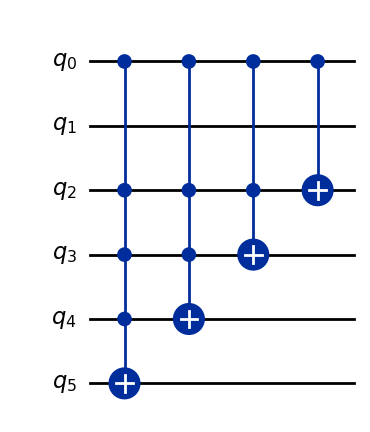

In [35]:
def add2kgate(k, n):
    '''Build a gate: input a return a+2^k mod 2^(n+1)'''
    qc = QuantumCircuit(n, name=f'add 2^{k}')
    if not k in list(range(n)):
        raise("ValueError: k not in [0,1,...,n-1]")
    if k == n-1:
        qc.x(k)
        return qc
    for i in range(n-k-1):
        qc.mcx(list(range(k, n-i-1)), n-i-1)
    qc.x(k)
    return qc

def cadd2kgate(k, n):
    '''Build a controlled gate: input a return a+2^k mod 2^(n+1)'''
    qc = QuantumCircuit(n+1, name=f'c_add 2^{k}')
    if not k in list(range(n)):
        raise("ValueError: k not in [0,1,...,n-1]")
    if k == n-1:
        qc.cx(0, k+1)
        return qc
    for i in range(n-k-1):
        qc.mcx([0]+list(range(k+1, n-i)), n-i)
    qc.cx(0, k+1)   
    return qc

k = 1
qc = QuantumCircuit(n+1)
for i in range(n-k-1):
    qc.mcx([0]+list(range(k+1, n-i)), n-i)
qc.cx(0, k+1)
qc.draw(output='mpl') 

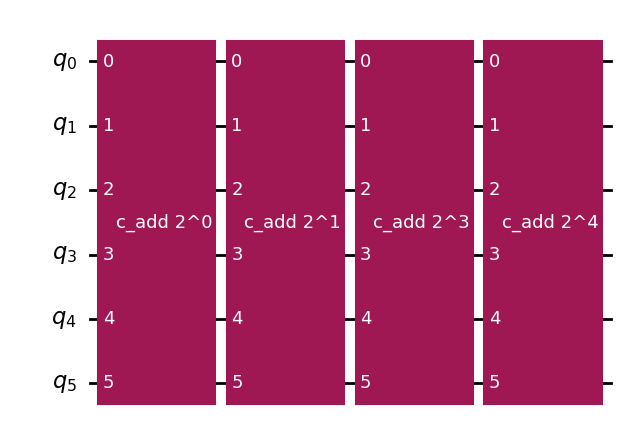

In [36]:
def addagate(a, n):
    '''add a'''
    qc = QuantumCircuit(n, name=f'add {a}')
    a = bin(a % 2**n)[2:].zfill(n)
    for i in range(n):
        if a[n-i-1] == '1':
            qc.append(add2kgate(i, n), list(range(n)))
    return qc

def caddagate(a, n):
    '''controlled add a'''
    qc = QuantumCircuit(n+1, name=f'c_add {a}')
    a = bin(a % 2**n)[2:].zfill(n)
    for i in range(n):
        if a[n-i-1] == '1':
            qc.append(cadd2kgate(i, n), list(range(n+1)))
    return qc

qc = QuantumCircuit(n+1)
a = bin((-5) % 2**n)[2:].zfill(n)
for i in range(n):
    if a[n-i-1] == '1':
        qc.append(cadd2kgate(i, n), range(n+1))
qc.draw(output='mpl')

In [52]:
tested_gate = addagate(-29, n)
for l in itertools.product([0, 1], repeat=n-1):
    qc = QuantumCircuit(n)
    for i in range(n-1):
        if l[n-2-i] == 1:
            qc.x(i)
    qc.append(tested_gate, range(n))
    qc.measure_all()
    job = backend.run(transpile(qc, backend), shots=16)
    res_dict = job.result().get_counts()
    res = res_dict.most_frequent()
    string_l = ['0']+[str(item) for item in l] 
    string_l = ''.join(string_l)
    print(f"{string_l} -> {res}")

00000 -> 00011
00001 -> 00100
00010 -> 00101
00011 -> 00110
00100 -> 00111
00101 -> 01000
00110 -> 01001
00111 -> 01010
01000 -> 01011
01001 -> 01100
01010 -> 01101
01011 -> 01110
01100 -> 01111
01101 -> 10000
01110 -> 10001
01111 -> 10010


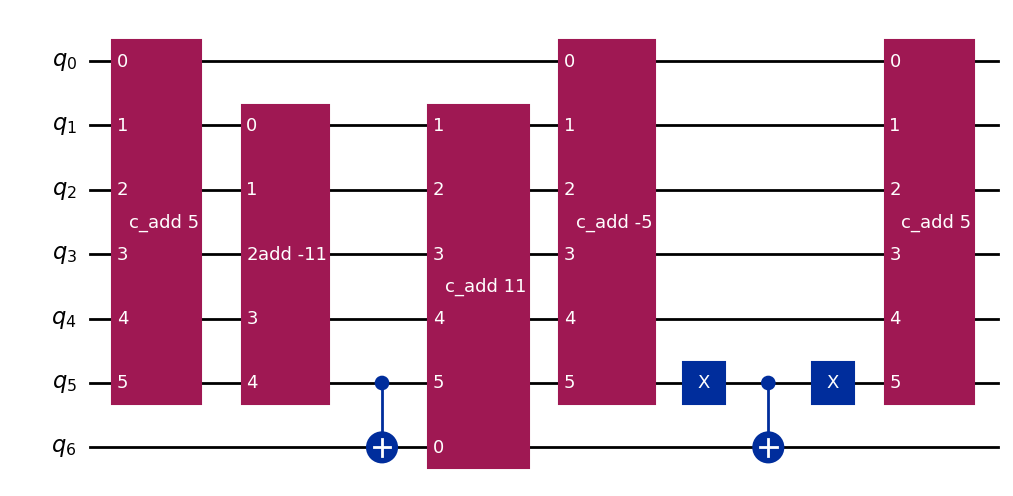

In [44]:
def caddmodgate(a, m, n):
    '''controlled add a mod m on n+1 qubits
    qubit[0]: control
    qubit[1:n]: input summand
    qubit[n+1]: auxiliary
    '''
    qc = QuantumCircuit(n+2, name=f'c_add{a}mod{m}')
    qc.append(caddagate(a, n), range(n+1))
    qc.append(addagate(-m, n), range(1, n+1))
    qc.cx(n, n+1)
    qc.append(caddagate(m, n), [n+1]+list(range(1, n+1)))
    qc.append(caddagate(-a, n), range(n+1))
    qc.x(n)
    qc.cx(n, n+1)
    qc.x(n)
    qc.append(caddagate(a, n), range(n+1))
    return qc

a = 5
m = 11
qc = QuantumCircuit(n+2)
qc.append(caddagate(a, n), range(n+1))
qc.append(addagate(-m, n), range(1, n+1))
qc.cx(n, n+1)
qc.append(caddagate(m, n), [n+1]+list(range(1, n+1)))
qc.append(caddagate(-a, n), range(n+1))
qc.x(n)
qc.cx(n, n+1)
qc.x(n)
qc.append(caddagate(a, n), range(n+1))
qc.draw(output='mpl')

In [55]:
tested_gate = caddmodgate(0, 11, n)
for l in itertools.product([0, 1], repeat=n-1):
    qc = QuantumCircuit(n+2)
    qc.x(0)
    for i in range(n-1):
        if l[n-2-i] == 1:
            qc.x(i+1)
    qc.append(tested_gate, range(n+2))
    qc.measure_all()
    job = backend.run(transpile(qc, backend), shots=16)
    res_dict = job.result().get_counts()
    res = res_dict.most_frequent()
    string_l = [str(item) for item in l] 
    string_l = ''.join(string_l)
    print(f"{''.join(string_l)} -> {res}")

0000 -> 0000001
0001 -> 0000011
0010 -> 0000101
0011 -> 0000111
0100 -> 0001001
0101 -> 0001011
0110 -> 0001101
0111 -> 0001111
1000 -> 0010001
1001 -> 0010011
1010 -> 0010101
1011 -> 1000001
1100 -> 1000011
1101 -> 1000101
1110 -> 1000111
1111 -> 1001001


In [66]:
a = 5
m = 11
tested_gate = caddmodgate(a, m, n)
print("a, b should be smaller than m")
for dec_b in range(m):
    b = bin(dec_b)[2:].zfill(n)
    qc = QuantumCircuit(n+2)
    qc.x(0)
    for i in range(n):
        if b[n-1-i] == '1':
            qc.x(i+1)
    qc.append(tested_gate, range(n+2))
    qc.measure_all()
    job = backend.run(transpile(qc, backend), shots=16)
    res_dict = job.result().get_counts()
    aux = res_dict.most_frequent()[0]
    res = res_dict.most_frequent()[1:n+1]
    dec_res = 0
    for i in range(n):
        if res[n-1-i] == '1':
            dec_res += 2**i
    print(f"{b} -> {res},  {a} + {dec_b} = {dec_res} mod {m}, auxi_bit = {aux}")

a, b should be smaller than m
00000 -> 00101,  5 + 0 = 5 mod 11, auxi_bit = 0
00001 -> 00110,  5 + 1 = 6 mod 11, auxi_bit = 0
00010 -> 00111,  5 + 2 = 7 mod 11, auxi_bit = 0
00011 -> 01000,  5 + 3 = 8 mod 11, auxi_bit = 0
00100 -> 01001,  5 + 4 = 9 mod 11, auxi_bit = 0
00101 -> 01010,  5 + 5 = 10 mod 11, auxi_bit = 0
00110 -> 00000,  5 + 6 = 0 mod 11, auxi_bit = 0
00111 -> 00001,  5 + 7 = 1 mod 11, auxi_bit = 0
01000 -> 00010,  5 + 8 = 2 mod 11, auxi_bit = 0
01001 -> 00011,  5 + 9 = 3 mod 11, auxi_bit = 0
01010 -> 00100,  5 + 10 = 4 mod 11, auxi_bit = 0


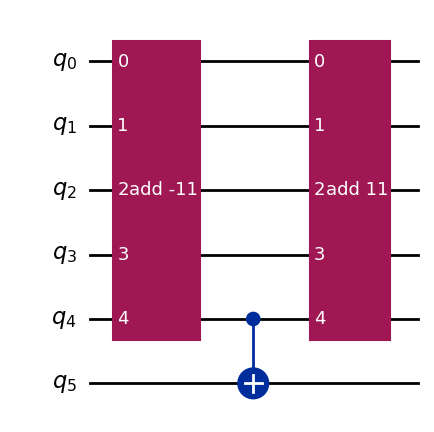

In [67]:
def comparegate(m, n):
    '''if input < m
    qubits[0:n]: input
    qubits[n+1]: (input < m)
    '''
    qc = QuantumCircuit(n+1, name=f'if b<{m}')
    qc.append(addagate(-m, n), range(n))
    qc.cx(n-1, n)
    qc.append(addagate(m, n), range(n))
    return qc

qc = QuantumCircuit(n+1, name=f'if b<{m}')
qc.append(addagate(-m, n), range(n))
qc.cx(n-1, n)
qc.append(addagate(m, n), range(n))
qc.draw(output='mpl')

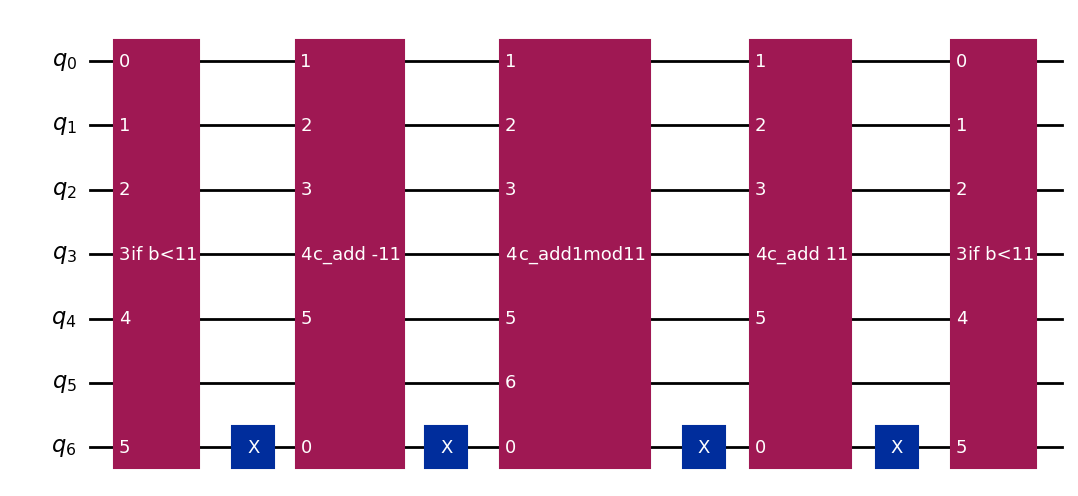

In [77]:
def partshiftgate(a, m, n):
    '''
    if b<m, return a+b mod m. else return b.
    qubits[0:n-1]: input
    qubits[n, n+1]: auxiliary
    m satisfied 2^(n-2) < m < 2^(n-1)
    '''
    qc = QuantumCircuit(n+2, name='partshiftgate')
    qc.append(comparegate(m, n), list(range(n))+[n+1])
    qc.x(n+1)
    qc.append(caddagate(-m, n), [n+1]+list(range(n)))
    qc.x(n+1)
    qc.append(caddmodgate(a, m, n), [n+1]+list(range(n+1)))
    qc.x(n+1)
    qc.append(caddagate(m, n), [n+1]+list(range(n)))
    qc.x(n+1)
    qc.append(comparegate(m, n), list(range(n))+[n+1])
    return qc

qc = QuantumCircuit(n+2, name='partshiftgate')
qc.append(comparegate(m, n), list(range(n))+[n+1])
qc.x(n+1)
qc.append(caddagate(-m, n), [n+1]+list(range(n)))
qc.x(n+1)
qc.append(caddmodgate(a, m, n), [n+1]+list(range(n+1)))
qc.x(n+1)
qc.append(caddagate(m, n), [n+1]+list(range(n)))
qc.x(n+1)
qc.append(comparegate(m, n), list(range(n))+[n+1])
qc.draw(output='mpl')
    

In [87]:
a = 2
m = 11
print("Reqiures: 2**(n-2) < m < 2**(n-1), 0 <= a < m")
tested_gate = partshiftgate(a, m, n)
for dec_b in range(2**(n-1)):
    b = bin(dec_b)[2:].zfill(n)
    qc = QuantumCircuit(n+2)
    for i in range(n):
        if b[n-1-i] == '1':
            qc.x(i)
    qc.append(tested_gate, range(n+2))
    qc.measure_all()
    job = backend.run(transpile(qc, backend), shots=16)
    res_dict = job.result().get_counts()
    aux = res_dict.most_frequent()[:2]
    res = res_dict.most_frequent()[2:]
    dec_res = 0
    for i in range(n):
        if res[n-1-i] == '1':
            dec_res += 2**i
    print(f"{b} -> {res},  {dec_b} -> {dec_res}, auxi_bit = {aux}")


Reqiures: 2**(n-2) < m < 2**(n-1), 0 <= a < m
00000 -> 00010,  0 -> 2, auxi_bit = 00
00001 -> 00011,  1 -> 3, auxi_bit = 00
00010 -> 00100,  2 -> 4, auxi_bit = 00
00011 -> 00101,  3 -> 5, auxi_bit = 00
00100 -> 00110,  4 -> 6, auxi_bit = 00
00101 -> 00111,  5 -> 7, auxi_bit = 00
00110 -> 01000,  6 -> 8, auxi_bit = 00
00111 -> 01001,  7 -> 9, auxi_bit = 00
01000 -> 01010,  8 -> 10, auxi_bit = 00
01001 -> 00000,  9 -> 0, auxi_bit = 00
01010 -> 00001,  10 -> 1, auxi_bit = 00
01011 -> 01011,  11 -> 11, auxi_bit = 00
01100 -> 01100,  12 -> 12, auxi_bit = 00
01101 -> 01101,  13 -> 13, auxi_bit = 00
01110 -> 01110,  14 -> 14, auxi_bit = 00
01111 -> 01111,  15 -> 15, auxi_bit = 00
